In [3383]:
import os
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt

from src.utils.argparsing import get_args

pd.set_option('display.max_rows', 500)

warnings.filterwarnings("ignore")
sns.set(font="Helvetica")
ROOT = "/Users/sm2152/Documents/projects/feedback-DT/"

In [3384]:
def get_conditioning(row):
    """
    Returns a string describing the conditioning used for a given experiment.
    """
    conditioning = []
    if row["use_rtg"]:
        conditioning.append("rtg")
    if row["use_mission"]:
        conditioning.append("mission")
    if row["use_feedback"]:
        if row["feedback_mode"] != "all":
            conditioning.append(f"{row['feedback_mode']} feedback")
        else:
            conditioning.append("all feedback")
    return " + ".join(conditioning)

In [3385]:
def get_experiments(output_path, dir):
    """
    Returns a list of dataframes containing the results of all experiments in a given directory.
    """
    settings = dir.split("-")[5:]
    dfs = []
    for seed_dir in os.listdir(os.path.join(output_path, dir)):
        exp_path = os.path.join(output_path, os.path.join(dir, seed_dir))
        try:
            df = pd.read_pickle(os.path.join(exp_path, "results.pkl"))
            df["model_seed"] = seed_dir
        except:
            continue
        for s in settings:
            key = s.split("_")[:-1]
            key = "_".join(key)
            value = s.split("_")[-1]
            value = (
                int(value)
                if value.isnumeric()
                else (
                    True if value == "True" else (False if value == "False" else value)
                )
            )
            df[key] = value
        try:
            df["conditioning"] = df.apply(lambda row: get_conditioning(row), axis=1)
        except KeyError:
            raise KeyError("Could not generate conditioning column")
        dfs.append(df)
    return dfs

In [3386]:
def get_combined_df(output_path, level=None):
    """
    Returns a dataframe containing the results of all experiments in a given directory.
    """
    dfs = []
    for dir in os.listdir(output_path):
        if "level" in dir:
            if level and level.lower() not in dir:
                continue
            current_dfs = get_experiments(output_path, dir)
            dfs.extend(current_dfs)
    dfs = [df[(df["eval_type"] != "efficiency") & (df["model"] == "DT")] for df in dfs]
    return pd.concat(dfs, ignore_index=True)

In [3387]:
def aggr_results(df, inference_mode, eval_type, metric):
    """
    Returns a dataframe containing the aggregated results of a given evaluation type.
    """

    filtered_results = df[
        (df["eval_type"] == eval_type)
        & (
            (df["feedback_at_inference"] == inference_mode)
            | (pd.isna(df["feedback_at_inference"]))
        )
    ]

    results = (
        filtered_results[["conditioning",  metric]]
        .groupby(["conditioning"])
        .agg(
            Mean=(metric, "mean"),
            Std=(metric, "std"),
            Min=(metric, "min"),
            Max=(metric, "max"),
        )
    )
    results["Mean"] = results["Mean"].round(4)
    results["Std"] = results["Std"].round(4)
    
    results["ood_type"] = 'all types' if eval_type == "ood_generalisation" else None
    results["eval_type"] = eval_type
    results["feedback_at_inference"] = inference_mode

    if eval_type == "ood_generalisation":
        results_by_ood = (
            filtered_results[["ood_type", "conditioning",  metric]]
            .groupby(["ood_type", "conditioning"])
            .agg(
                Mean=(metric, "mean"),
                Std=(metric, "std"),
                Min=(metric, "min"),
                Max=(metric, "max"),
            )
        )
        results_by_ood["Mean"] = results_by_ood["Mean"].round(4)
        results_by_ood["Std"] = results_by_ood["Std"].round(4)
        
        results_by_ood["eval_type"] = eval_type
        results_by_ood["feedback_at_inference"] = inference_mode
    else:
        results_by_ood = None

    return results, results_by_ood

In [3388]:
def get_deltas(df, reference):
    """
    Returns a dataframe containing the deltas of a given dataframe with respect to a reference (mission or RTG).
    """
    delta_df = df[
        (df["conditioning"].str.contains(reference))
        | (df["conditioning"] == "all feedback")
    ]
    delta_df["Delta (Mean)"] = delta_df.apply(
        lambda row: row["Mean"]
        - delta_df.loc[delta_df["conditioning"] == reference, "Mean"].values[0],
        axis=1,
    )
    delta_df["Delta (Mean)"] = delta_df["Delta (Mean)"].round(4)
    delta_df["reference"] = reference
    return delta_df

In [3389]:
def combine_results(df, metric):
    """
    Returns a dataframe containing the aggregated results of all evaluation types.
    """
    dfs = []
    for reference in ["mission", "rtg"]:
        for inference_mode in df["feedback_at_inference"].unique():
            if pd.isna(inference_mode):
                continue
            for eval_type in df["eval_type"].unique():
                results, results_by_ood = aggr_results(df, inference_mode, eval_type, metric)
                results.reset_index(inplace=True)
                
                results_with_deltas = get_deltas(results, reference)
                dfs.append(results_with_deltas)
                
                if results_by_ood is not None:
                    results_by_ood.reset_index(inplace=True)
                    for ood_type in results_by_ood["ood_type"].unique():
                        results_by_ood_with_deltas = get_deltas(results_by_ood[results_by_ood["ood_type"] == ood_type], reference)
                        dfs.append(results_by_ood_with_deltas)
    display(pd.concat(dfs, ignore_index=True))
    return pd.concat(dfs, ignore_index=True)

In [3390]:
def save_results_as_csv(df, level, metric, output_path):
    """
    Saves a dataframe as a csv file.
    """
    path = os.path.join(output_path, f"results_{level}_{metric}.csv")
    df.to_csv(path)

In [3391]:
def map_colors(df, colors):
    """
    Returns a dictionary mapping conditioning variants to colors for plots.
    """
    labels = list(df["conditioning"].unique())
    return {
        label: colors["uoe_si_colors"][i + 1]
        if "mission" in label
        else (
            colors["hwu_colors"][0]
            if label == "all feedback"
            else colors["aarg_colors"][i]
        )
        for i, label in enumerate(labels)
    }


In [3392]:
def set_axis_ticks(ax, reference, reference_perf, ylims, sizing_config):
    """
    Sets the reference performance on the y-axis (instead of 0).
    """
    ax.set_ylim(bottom=-ylims, top=ylims)
    yticklabels = ax.get_yticks().tolist()

    new_yticklabels = [
        f"{reference_perf:.2f}*"
        if float(ytick) == float(0)
        else (f"+{ytick:.2f}" if float(ytick) > float(0) else f"{ytick:.2f}")
        for ytick in yticklabels
    ]
    ax.set_yticklabels(new_yticklabels, fontsize=sizing_config["tick_label_size"])
    xticklabels = ax.get_xticklabels()
    new_xticklabels = [
        f"vs {label.get_text()}".replace(f"vs {reference}", "").replace(
            "feedback", "\nfeedback"
        )
        for label in xticklabels
    ]
    ax.set_xticklabels(new_xticklabels, fontsize=sizing_config["tick_label_size"])
    plt.tight_layout(pad=0.5)

In [3393]:
def set_bar_values(ax, df, ylims, sizing_config):
    """
    Sets the values of the bars on top of the bars (for positive deltas)
    / below the bars (for negatvie deltas).
    """
    for index, value in enumerate(df["Delta (Mean)"]):
        x_pos = index
        y_pos = value + ylims / 25 if value > 0 else value - ylims / 25
        va = "bottom" if value > 0 else "top"
        ax.text(
            x_pos,
            y_pos,
            f"{value:.2f}",
            ha="center",
            va=va,
            fontsize=sizing_config["value_size"],
        )
    plt.tight_layout(pad=0.5)

In [3394]:
def set_pad_title(level, eval_type, inference_mode, sizing_config):
    """
    Sets the title of the plot, with padding.
    """
    if "all" in level:
        level = level.replace('_', ' ')
    else:
        level = "level " + f"'{level}'"
    plt.title(
        f"{eval_type.replace('_', ' ')} on {level} \n({inference_mode} feedback at inference)",
        fontsize=sizing_config["title_size"],
    )
    plt.tight_layout(pad=0.5)

In [3395]:
def set_pad_axis_labels(ax, metric, reference, sizing_config):
    """
    Sets the labels of the x and y axes, with padding.
    """
    ax.set_xlabel(
        "Conditioning variant",
        fontsize=sizing_config["axis_label_size"],
        wrap=True,
    )
    ax.set_ylabel(
        f"Δ {metric.replace('_', ' ')}{' rate' if metric == 'gc_success' else ''}\n*{reference}",
        fontsize=sizing_config["axis_label_size"],
        labelpad=sizing_config["axis_label_size"] * 0.75,
        wrap=True,
    )
    ax.tick_params(axis="both", which="major", pad=-2)
    plt.tight_layout(pad=0.5)

In [3396]:
def get_plot_config(size):
    figma_dpi = 72
    small_height = 132 / figma_dpi
    medium_height = 198 / figma_dpi
    large_height = 396 / figma_dpi
    full_width = 396 / figma_dpi
    half_width = 190.5 / figma_dpi
    third_width = 122 / figma_dpi

    xsmall_font_size = 6
    small_font_size = 9
    medium_font_size = 10
    large_font_size = 14
    xlarge_font_size = 16

    xsmall_font_set = (
        xsmall_font_size,
        xsmall_font_size,
        xsmall_font_size,
        xsmall_font_size,
    )

    small_font_set = (
        small_font_size,
        small_font_size,
        xsmall_font_size,
        xsmall_font_size,
    )
    medium_font_set = (
        large_font_size,
        medium_font_size,
        small_font_size,
        xsmall_font_size,
    )
    large_font_set = (
        xlarge_font_size,
        large_font_size,
        medium_font_size,
        small_font_size,
    )

    if size == "small-third":
        figsize = (third_width, small_height)
        font_sizes = xsmall_font_set
    elif size == "small-half":
        figsize = (half_width, small_height)
        font_sizes = xsmall_font_set
    elif size == "small":
        figsize = (full_width, small_height)
        font_sizes = small_font_set
    elif size == "medium-third":
        figsize = (third_width, medium_height)
        font_sizes = xsmall_font_set
    elif size == "medium-half":
        figsize = (half_width, medium_height)
        font_sizes = small_font_set
    elif size == "medium":
        figsize = (full_width, medium_height)
        font_sizes = medium_font_set
    elif size == "large-third":
        figsize = (third_width, large_height)
        font_sizes = medium_font_set
    elif size == "large-half":
        figsize = (half_width, large_height)
        font_sizes = large_font_set
    else:
        figsize = (full_width, large_height)
        font_sizes = large_font_set

    return {
        "figsize": figsize,
        "title_size": font_sizes[0],
        "axis_label_size": font_sizes[1],
        "tick_label_size": font_sizes[2],
        "value_size": font_sizes[3],
    }

In [3397]:
def plot_deltas_without_text(
    sizing_config,
    df,
    ylims,
    color_palette,
):
    fig1 = plt.figure(figsize=sizing_config["figsize"])
    ax1 = plt.subplot()
    sns.barplot(
        data=df,
        x="conditioning",
        y="Delta (Mean)",
        ax=ax1,
        errorbar=None,
        palette=color_palette,
    )
    plt.title(
        " \n ",
        fontsize=sizing_config["title_size"],
    )

    ax1.set_ylim(bottom=-ylims, top=ylims)

    ax1.set_xlabel(" ", fontsize=sizing_config["axis_label_size"])
    ax1.set_xticklabels([])

    ax1.set_ylabel(
        " \n ",
        fontsize=sizing_config["axis_label_size"],
        labelpad=sizing_config["axis_label_size"] * 2,
    )
    ax1.set_yticklabels([])

    plt.margins(x=0.025, y=0.025)
    plt.tight_layout(pad=0.5)

In [3398]:
def plot_deltas_with_text(
    sizing_config,
    df,
    level,
    metric,
    ylims,
    eval_type,
    reference,
    reference_perf,
    inference_mode,
    color_palette,
):
    fig2 = plt.figure(figsize=sizing_config["figsize"])
    ax2 = plt.subplot()
    sns.barplot(
        data=df,
        x="conditioning",
        y="Delta (Mean)",
        ax=ax2,
        errorbar=None,
        palette=color_palette,
    )
    set_axis_ticks(ax2, reference, reference_perf, ylims, sizing_config)
    set_bar_values(ax2, df, ylims, sizing_config)
    set_pad_title(level, eval_type, inference_mode, sizing_config)
    set_pad_axis_labels(ax2, metric, reference, sizing_config)
    plt.margins(x=0.025, y=0.025)
    plt.tight_layout(pad=0.5)

In [3399]:
def plot_deltas(
    df,
    level,
    metric,
    colors,
    size,
    ylims,
    eval_type,
    output_path,
    reference,
    reference_perf,
    inference_mode,
    ood_type=None,
):
    """
    Plots the deltas of a given dataframe with respect to a reference (mission or RTG).
    """
    color_palette = map_colors(df, colors)
    sizing_config = get_plot_config(size)
    eval_type = f"{eval_type.split('_')[0].upper()} generalisation{f' ({ood_type})' if ood_type else ''}"
    plot_deltas_with_text(
        sizing_config,
        df,
        level,
        metric,
        ylims,
        eval_type,
        reference,
        reference_perf,
        inference_mode,
        color_palette,
    )
    plt.savefig(
        os.path.join(output_path, f"{level}_{metric}_{eval_type}_{reference}_{inference_mode}.png"),
        bbox_inches="tight",
    )
    plot_deltas_without_text(sizing_config, df, ylims, color_palette)
    plt.savefig(
        os.path.join(
            output_path, f"{level}_{metric}_{eval_type}_{reference}_{inference_mode}_no_text.png"
        ),
        bbox_inches="tight",
    )
    plt.show()


In [3400]:
def plot_results(df, level, metric, colors, size, output_path):
    """
    Plots the results of a given dataframe.
    """
    ylims = max(abs(df["Delta (Mean)"].max()), abs(df["Delta (Mean)"].min())) * 1.25
    for reference in ["mission", "rtg"]:
        for eval_type in df["eval_type"].unique():
            for inference_mode in df["feedback_at_inference"].unique():
                if pd.isna(inference_mode):
                    continue

                for ood_type in df[df["eval_type"] == eval_type]["ood_type"].unique():
                    if pd.isna(ood_type):
                        results_with_ref = df[
                            (df["eval_type"] == eval_type)
                            & (df["reference"] == reference)
                            & (pd.isna(df["ood_type"]))
                            & ((df["feedback_at_inference"] == inference_mode) | (pd.isna(df["feedback_at_inference"])))
                        ]
                    else:
                        results_with_ref = df[
                            (df["eval_type"] == eval_type)
                            & (df["reference"] == reference)
                            & (df["ood_type"] == ood_type)
                            & ((df["feedback_at_inference"] == inference_mode) | (pd.isna(df["feedback_at_inference"])))
                        ]

                    reference_perf = results_with_ref[
                        results_with_ref["conditioning"] == reference
                    ]["Mean"].values[0]
                    results = results_with_ref[~df["conditioning"].isin(["mission", "rtg"])]
                    results.sort_values("conditioning", inplace=True)
                    
                    plot_deltas(
                        results,
                        level,
                        metric,
                        colors,
                        size,
                        ylims,
                        eval_type,
                        output_path,
                        reference,
                        reference_perf,
                        inference_mode,
                        ood_type,
                    )

In [3401]:
def get_inference_mode_diffs(results_df):
    x = results_df.sort_values(
        by=[
            "reference",
            "conditioning",
            "eval_type",
            "ood_type",
            "feedback_at_inference",
        ],
        ascending=False,
    )
    x["diff"] = x["Mean"].diff()
    x["diff"] = x["diff"].apply(lambda x: round(x, 4))
    x["diff"][x["feedback_at_inference"] == "numerical"] = 0
    inference_mode_diffs = x[
            [
                "conditioning",
                "eval_type",
                "ood_type",
                "diff",
            ]
        ][(~x["conditioning"].isin(["mission", "rtg"])) & (x["feedback_at_inference"] != "numerical")]
    display(
        inference_mode_diffs
    )
    return inference_mode_diffs

In [3402]:
metric ="gc_success"
level = ""

colors = {
    "aarg_colors": [
        "#2F8374",
        "#499385",
        "#63A297",
        "#7DB2A8",
        "#97C1BA",
        "#B1D1CB",
        "#CBE0DC",
        "#E5F0EE",
    ],
    "hwu_colors": [
        "#970E53",
        "#A42C69",
        "#B14A7E",
        "#BE6894",
        "#CB87A9",
        "#D8A5BF",
        "#E5C3D4",
        "#F2E1EA",
    ],
    "uoe_si_colors": [
        "#004f71",
        "#206583",
        "#407B94",
        "#6091A6",
        "#80A7B8",
        "#9FBDCA",
        "#BFD3DB",
        "#DFE9ED",
    ],
}
experiment_name = "conditioning"
size = "small-half"
data_home = f"{ROOT}/data/{experiment_name}/output"
output_path = f"{ROOT}/data/{experiment_name}/output/results"

if not os.path.exists(output_path):
    os.makedirs(output_path)

GOTOLOCAL


,conditioning,Mean,Std,Min,Max,ood_type,eval_type,feedback_at_inference,Delta (Mean),reference
0,all feedback,0.554688,0.498953,0.0,1.0,None,iid_generalisation,actual,0.1406,mission
1,mission,0.414062,0.494495,0.0,1.0,None,iid_generalisation,actual,0.0000,mission
2,mission + all feedback,0.312500,0.465334,0.0,1.0,None,iid_generalisation,actual,-0.1016,mission
3,mission + rule feedback,0.375000,0.486025,0.0,1.0,None,iid_generalisation,actual,-0.0391,mission
4,mission + task feedback,0.468750,0.500983,0.0,1.0,None,iid_generalisation,actual,0.0547,mission
5,all feedback,0.555556,0.497563,0.0,1.0,all types,ood_generalisation,actual,0.0661,mission
6,mission,0.489418,0.500551,0.0,1.0,all types,ood_generalisation,actual,0.0000,mission
7,mission + all feedback,0.256614,0.437343,0.0,1.0,all types,ood_generalisation,actual,-0.2328,mission
8,mission + rule feedback,0.288360,0.453600,0.0,1.0,all types,ood_generalisation,actual,-0.2011,mission
9,mission + task feedback,0.468254,0.499653,0.0,1.0,all types,ood_generalisation,actual,-0.0212,mission


,conditioning,eval_type,ood_type,diff
74,rtg + task feedback,ood_generalisation,size,-0.0080
69,rtg + task feedback,ood_generalisation,color_type,-0.0317
59,rtg + task feedback,ood_generalisation,all types,-0.0317
64,rtg + task feedback,ood_generalisation,agent_loc,-0.0555
54,rtg + task feedback,iid_generalisation,None,-0.0156
73,rtg + rule feedback,ood_generalisation,size,-0.0080
68,rtg + rule feedback,ood_generalisation,color_type,-0.0318
58,rtg + rule feedback,ood_generalisation,all types,-0.0106
63,rtg + rule feedback,ood_generalisation,agent_loc,0.0079
53,rtg + rule feedback,iid_generalisation,None,0.0000


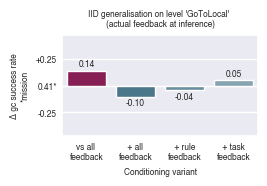

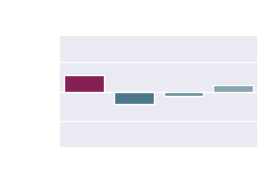

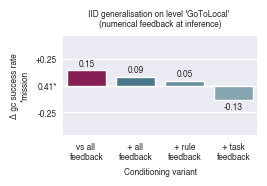

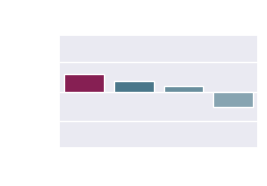

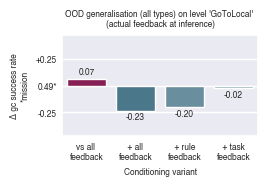

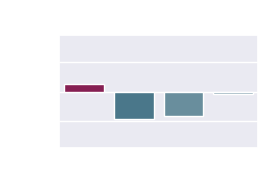

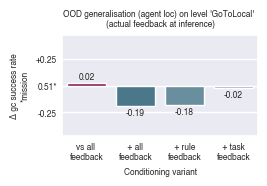

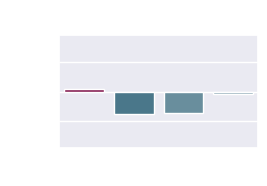

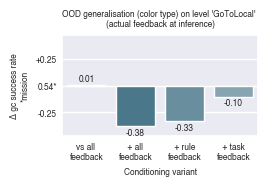

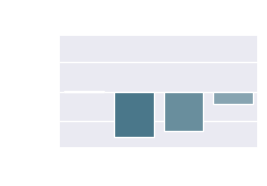

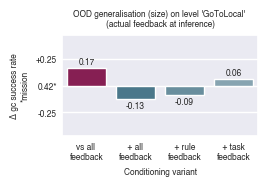

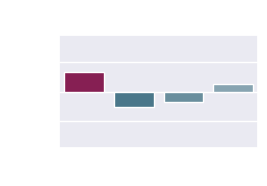

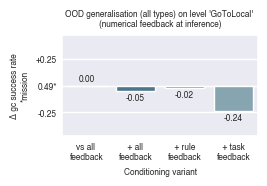

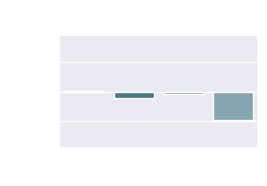

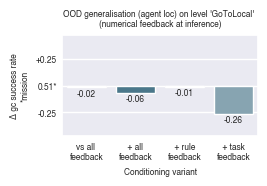

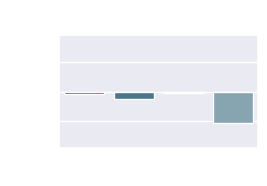

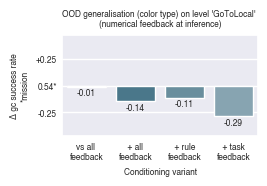

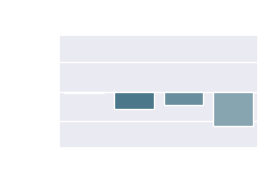

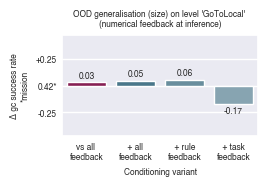

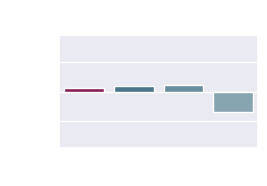

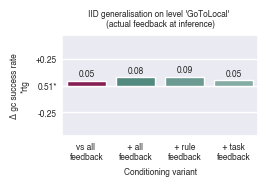

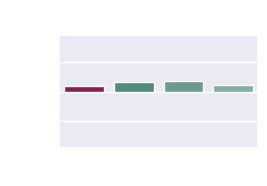

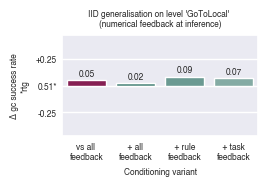

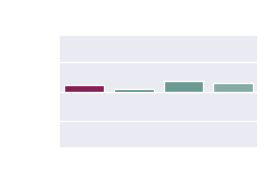

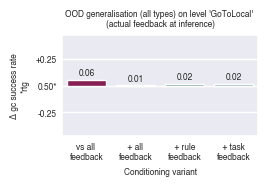

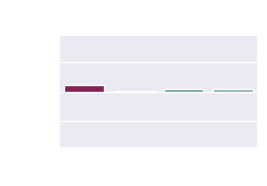

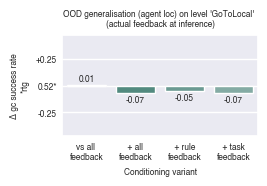

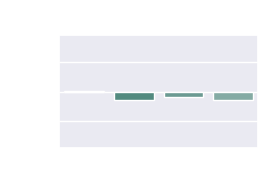

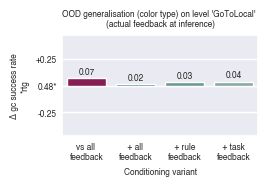

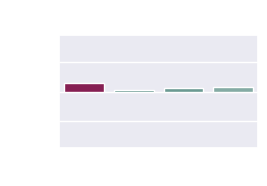

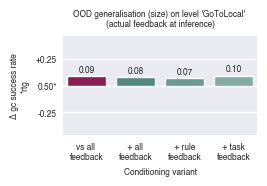

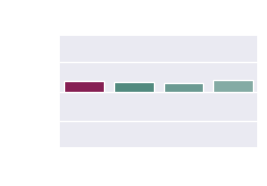

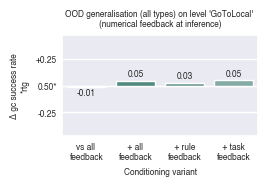

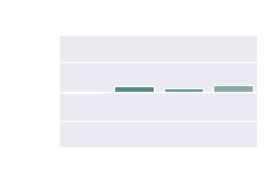

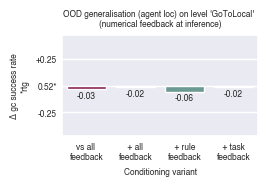

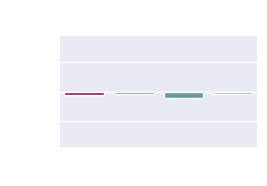

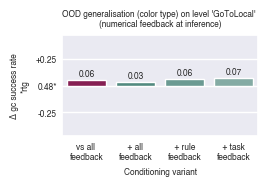

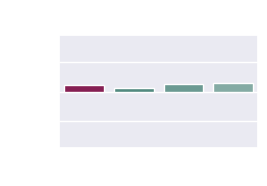

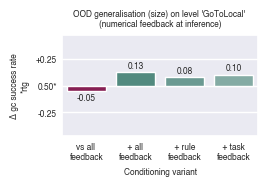

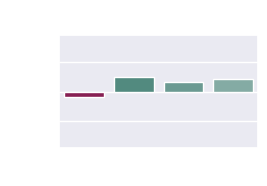

GOTOOBJ


,conditioning,Mean,Std,Min,Max,ood_type,eval_type,feedback_at_inference,Delta (Mean),reference
0,all feedback,0.437500,0.498028,0.0,1.0,None,iid_generalisation,numerical,0.0234,mission
1,mission,0.414062,0.494495,0.0,1.0,None,iid_generalisation,numerical,0.0000,mission
2,mission + all feedback,0.421875,0.495799,0.0,1.0,None,iid_generalisation,numerical,0.0078,mission
3,mission + rule feedback,0.390625,0.489808,0.0,1.0,None,iid_generalisation,numerical,-0.0234,mission
4,mission + task feedback,0.437500,0.498028,0.0,1.0,None,iid_generalisation,numerical,0.0234,mission
5,all feedback,0.515625,0.500408,0.0,1.0,all types,ood_generalisation,numerical,-0.0052,mission
6,mission,0.520833,0.500218,0.0,1.0,all types,ood_generalisation,numerical,0.0000,mission
7,mission + all feedback,0.445312,0.497649,0.0,1.0,all types,ood_generalisation,numerical,-0.0755,mission
8,mission + rule feedback,0.432292,0.496041,0.0,1.0,all types,ood_generalisation,numerical,-0.0885,mission
9,mission + task feedback,0.427083,0.495300,0.0,1.0,all types,ood_generalisation,numerical,-0.0938,mission


,conditioning,eval_type,ood_type,diff
99,rtg + task feedback,ood_generalisation,size,-0.3281
94,rtg + task feedback,ood_generalisation,color_type,-0.2422
84,rtg + task feedback,ood_generalisation,all types,-0.2057
89,rtg + task feedback,ood_generalisation,agent_loc,-0.0469
79,rtg + task feedback,iid_generalisation,None,-0.1406
98,rtg + rule feedback,ood_generalisation,size,-0.3047
93,rtg + rule feedback,ood_generalisation,color_type,-0.1562
83,rtg + rule feedback,ood_generalisation,all types,-0.2031
88,rtg + rule feedback,ood_generalisation,agent_loc,-0.1485
78,rtg + rule feedback,iid_generalisation,None,-0.1172


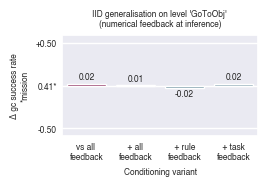

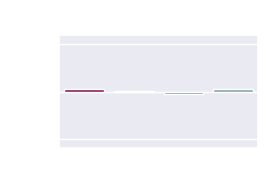

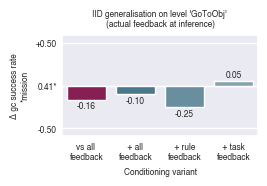

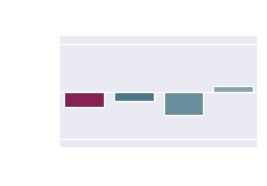

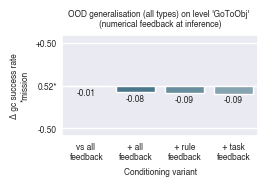

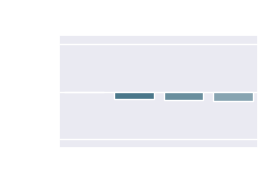

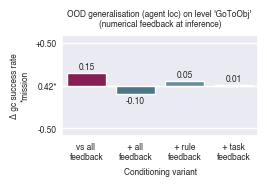

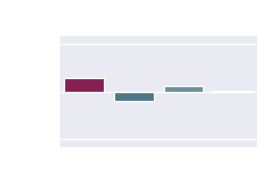

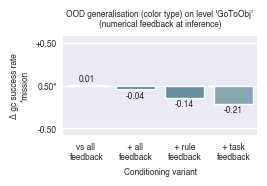

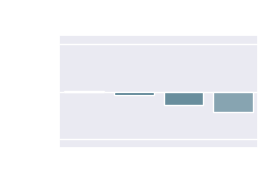

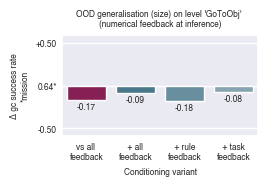

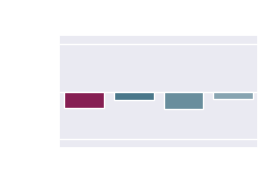

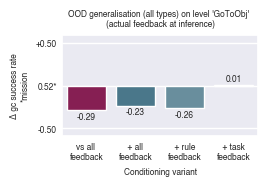

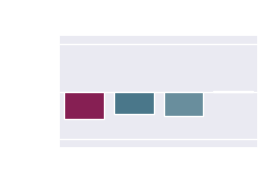

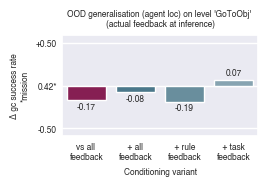

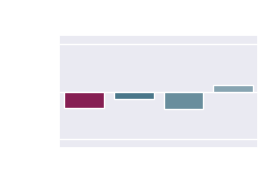

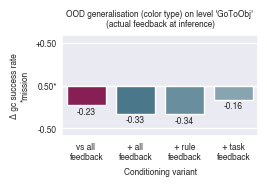

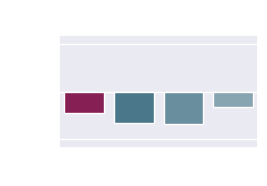

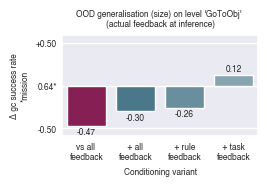

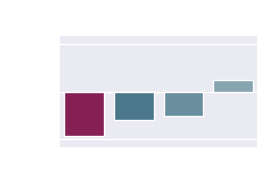

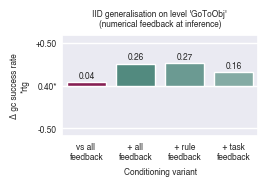

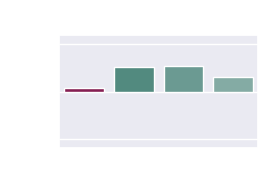

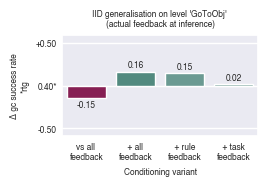

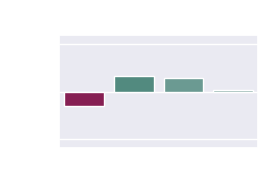

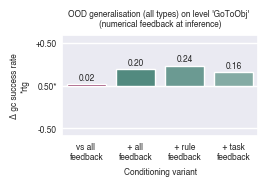

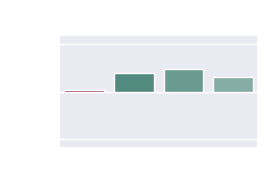

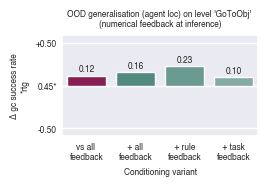

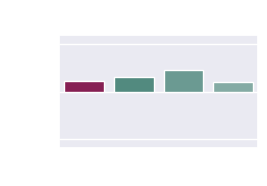

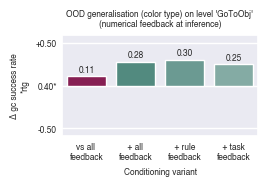

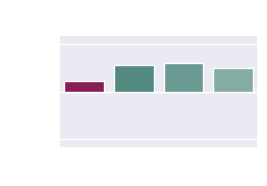

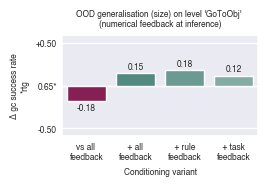

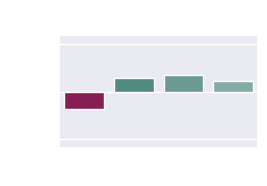

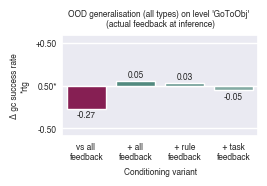

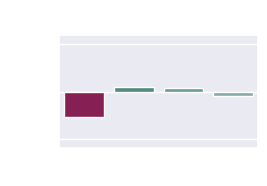

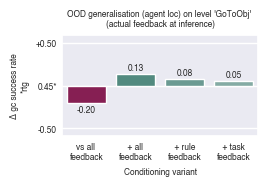

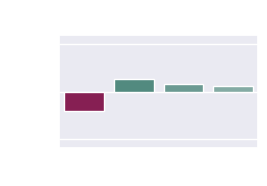

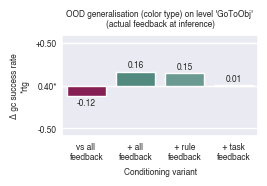

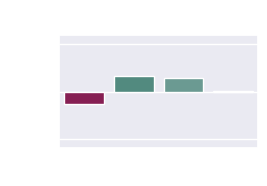

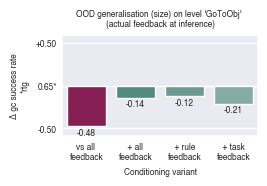

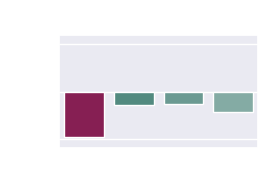

PICKUP


,conditioning,Mean,Std,Min,Max,ood_type,eval_type,feedback_at_inference,Delta (Mean),reference
0,all feedback,0.191406,0.355614,0.0,1.0,None,iid_generalisation,actual,0.0352,mission
1,mission,0.156250,0.312155,0.0,1.0,None,iid_generalisation,actual,0.0000,mission
2,mission + all feedback,0.109375,0.265744,0.0,1.0,None,iid_generalisation,actual,-0.0469,mission
3,mission + rule feedback,0.156250,0.312155,0.0,1.0,None,iid_generalisation,actual,0.0000,mission
4,mission + task feedback,0.214844,0.395265,0.0,1.0,None,iid_generalisation,actual,0.0586,mission
5,all feedback,0.201172,0.372536,0.0,1.0,all types,ood_generalisation,actual,0.0918,mission
6,mission,0.109375,0.268894,0.0,1.0,all types,ood_generalisation,actual,0.0000,mission
7,mission + all feedback,0.152344,0.322725,0.0,1.0,all types,ood_generalisation,actual,0.0430,mission
8,mission + rule feedback,0.160156,0.283076,0.0,1.0,all types,ood_generalisation,actual,0.0508,mission
9,mission + task feedback,0.208984,0.388912,0.0,1.0,all types,ood_generalisation,actual,0.0996,mission


,conditioning,eval_type,ood_type,diff
51,rtg + all feedback,ood_generalisation,color_type,-0.0704
45,rtg + all feedback,ood_generalisation,all types,-0.0723
48,rtg + all feedback,ood_generalisation,agent_loc,-0.0742
42,rtg + all feedback,iid_generalisation,None,-0.0664
49,all feedback,ood_generalisation,color_type,-0.0078
43,all feedback,ood_generalisation,all types,-0.0039
46,all feedback,ood_generalisation,agent_loc,0.0000
40,all feedback,iid_generalisation,None,-0.0547
19,mission + task feedback,ood_generalisation,color_type,0.0508
9,mission + task feedback,ood_generalisation,all types,0.0430


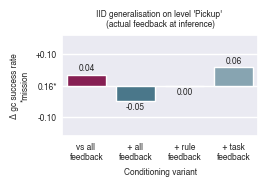

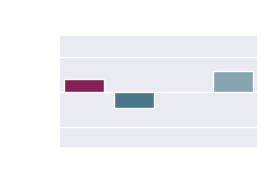

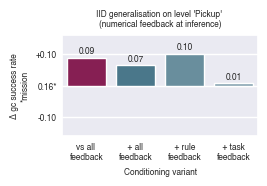

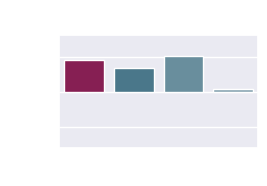

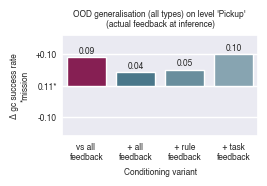

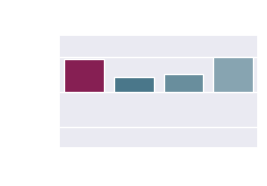

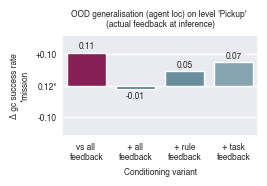

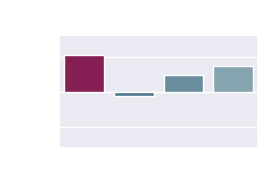

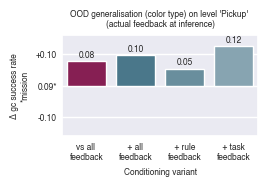

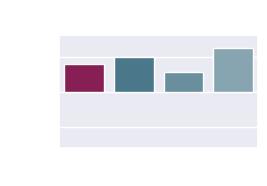

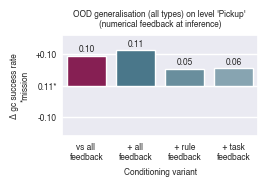

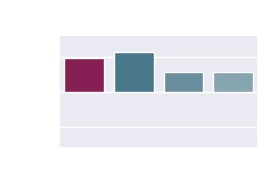

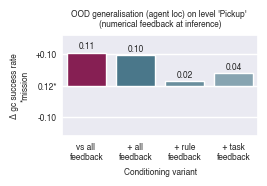

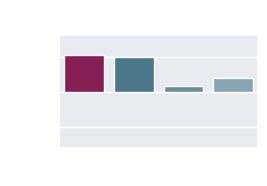

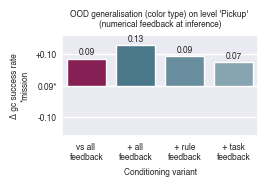

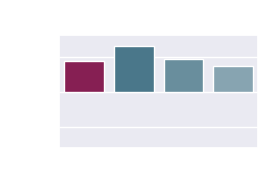

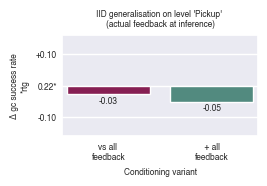

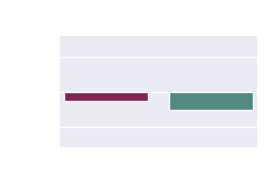

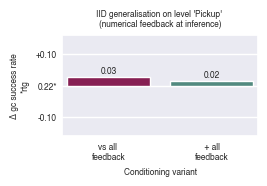

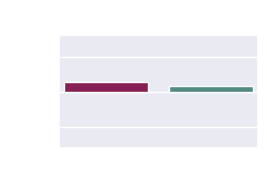

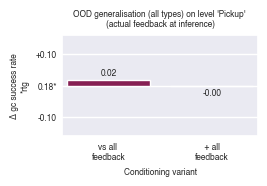

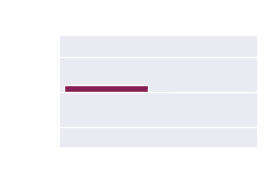

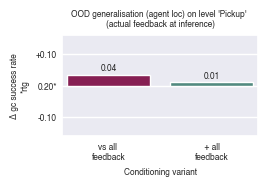

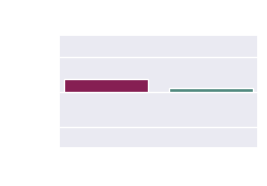

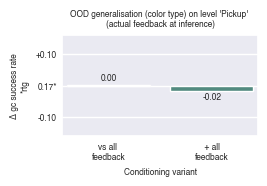

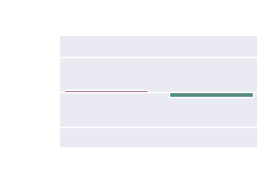

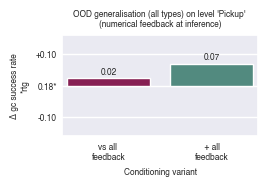

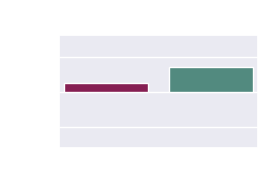

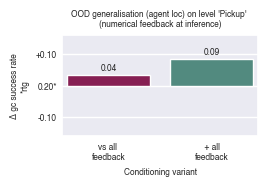

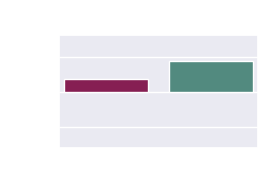

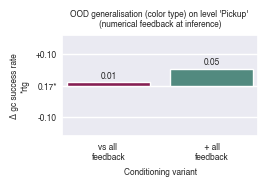

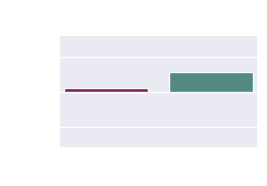

PICKUPLOC


,conditioning,Mean,Std,Min,Max,ood_type,eval_type,feedback_at_inference,Delta (Mean),reference
0,all feedback,0.359375,0.401461,0.0,1.0,None,iid_generalisation,actual,0.1289,mission
1,mission,0.230469,0.354401,0.0,1.0,None,iid_generalisation,actual,0.0000,mission
2,mission + all feedback,0.222656,0.364835,0.0,1.0,None,iid_generalisation,actual,-0.0078,mission
3,mission + rule feedback,0.218750,0.369880,0.0,1.0,None,iid_generalisation,actual,-0.0117,mission
4,mission + task feedback,0.269531,0.331439,0.0,1.0,None,iid_generalisation,actual,0.0391,mission
5,all feedback,0.256510,0.350247,0.0,1.0,all types,ood_generalisation,actual,0.0273,mission
6,mission,0.229167,0.338301,0.0,1.0,all types,ood_generalisation,actual,0.0000,mission
7,mission + all feedback,0.218750,0.356312,0.0,1.0,all types,ood_generalisation,actual,-0.0104,mission
8,mission + rule feedback,0.260417,0.371850,0.0,1.0,all types,ood_generalisation,actual,0.0313,mission
9,mission + task feedback,0.268229,0.338451,0.0,1.0,all types,ood_generalisation,actual,0.0391,mission


,conditioning,eval_type,ood_type,diff
74,rtg + task feedback,ood_generalisation,rel_loc,-0.0234
69,rtg + task feedback,ood_generalisation,color_type,0.0430
59,rtg + task feedback,ood_generalisation,all types,0.0143
64,rtg + task feedback,ood_generalisation,agent_loc,0.0234
54,rtg + task feedback,iid_generalisation,None,0.0039
73,rtg + rule feedback,ood_generalisation,rel_loc,0.0390
68,rtg + rule feedback,ood_generalisation,color_type,0.0234
58,rtg + rule feedback,ood_generalisation,all types,-0.0182
63,rtg + rule feedback,ood_generalisation,agent_loc,-0.1172
53,rtg + rule feedback,iid_generalisation,None,-0.0312


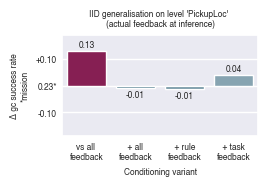

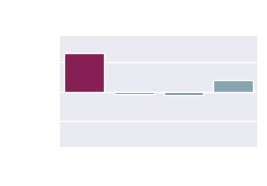

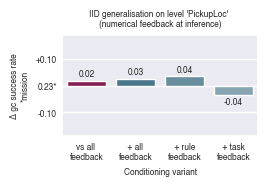

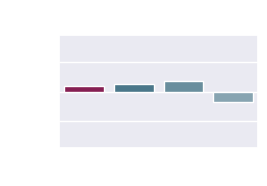

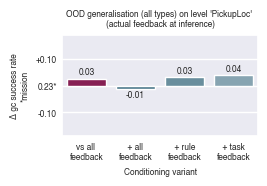

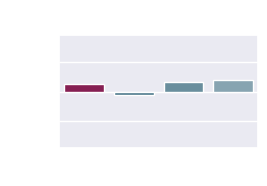

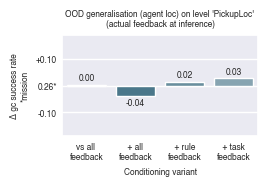

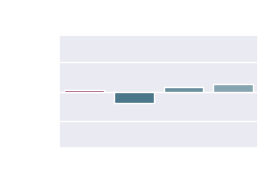

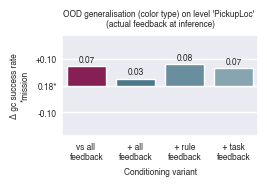

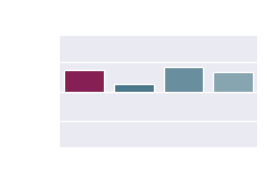

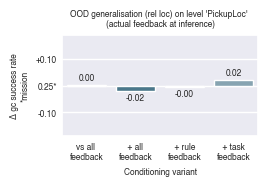

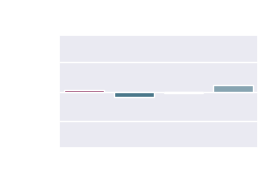

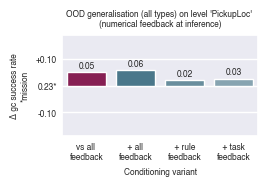

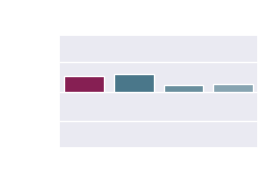

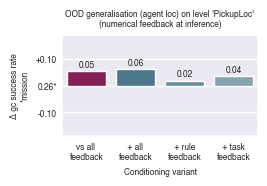

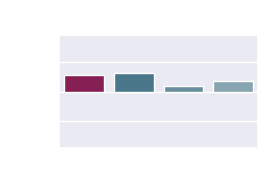

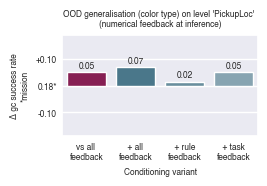

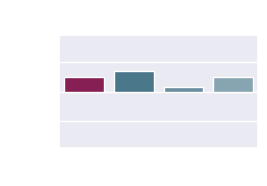

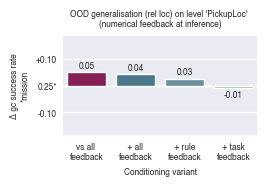

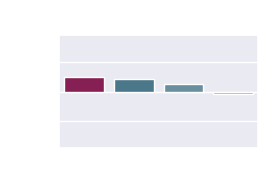

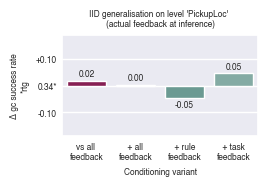

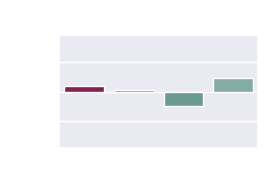

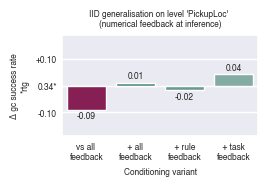

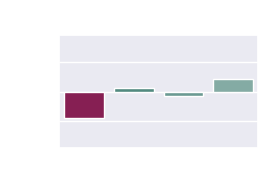

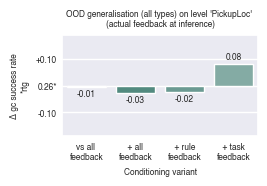

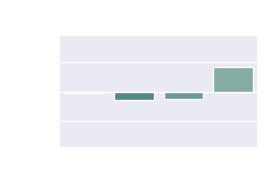

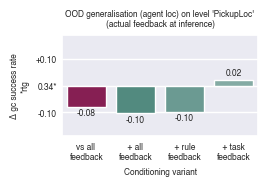

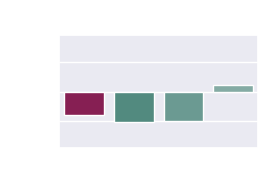

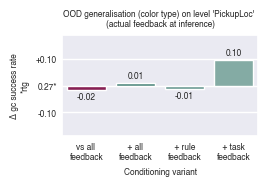

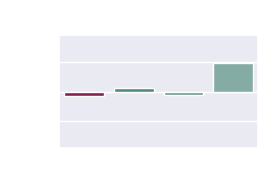

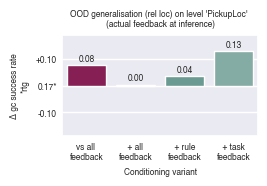

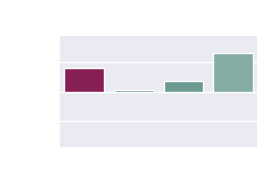

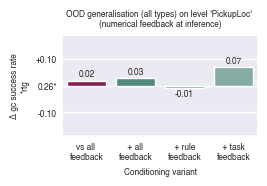

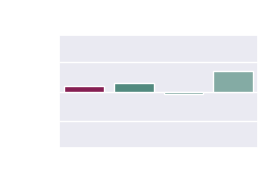

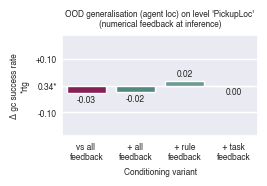

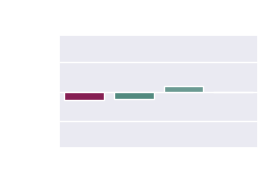

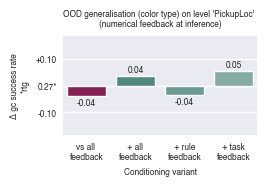

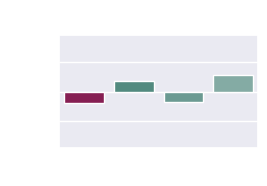

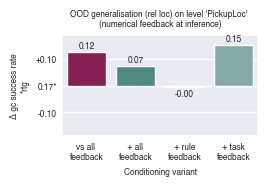

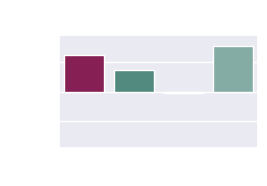

PUTNEXT


,conditioning,Mean,Std,Min,Max,ood_type,eval_type,feedback_at_inference,Delta (Mean),reference
0,all feedback,0.304688,0.236729,0.0,1.00,None,iid_generalisation,numerical,0.0488,mission
1,mission,0.255859,0.233648,0.0,1.00,None,iid_generalisation,numerical,0.0000,mission
2,mission + all feedback,0.318359,0.207428,0.0,1.00,None,iid_generalisation,numerical,0.0625,mission
3,mission + rule feedback,0.357422,0.242371,0.0,1.00,None,iid_generalisation,numerical,0.1016,mission
4,mission + task feedback,0.240234,0.211394,0.0,0.75,None,iid_generalisation,numerical,-0.0156,mission
5,all feedback,0.318359,0.263131,0.0,1.00,all types,ood_generalisation,numerical,0.0645,mission
6,mission,0.253906,0.240317,0.0,1.00,all types,ood_generalisation,numerical,0.0000,mission
7,mission + all feedback,0.310547,0.217719,0.0,1.00,all types,ood_generalisation,numerical,0.0566,mission
8,mission + rule feedback,0.374349,0.263040,0.0,1.00,all types,ood_generalisation,numerical,0.1204,mission
9,mission + task feedback,0.250651,0.230293,0.0,1.00,all types,ood_generalisation,numerical,-0.0033,mission


,conditioning,eval_type,ood_type,diff
79,rtg + all feedback,ood_generalisation,size,0.0195
76,rtg + all feedback,ood_generalisation,object_task,-0.0176
73,rtg + all feedback,ood_generalisation,color_type,-0.0332
70,rtg + all feedback,ood_generalisation,all types,-0.0104
67,rtg + all feedback,iid_generalisation,None,0.0020
77,all feedback,ood_generalisation,size,0.0332
74,all feedback,ood_generalisation,object_task,-0.1035
71,all feedback,ood_generalisation,color_type,-0.0528
68,all feedback,ood_generalisation,all types,-0.0410
65,all feedback,iid_generalisation,None,-0.0234


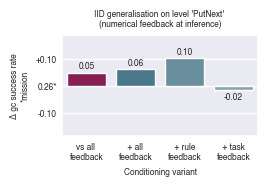

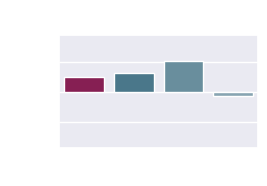

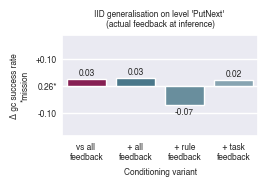

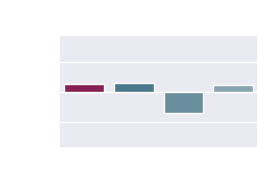

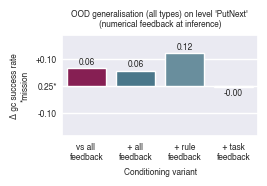

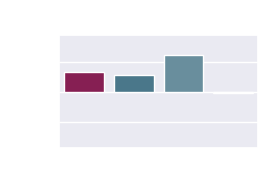

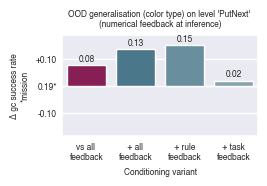

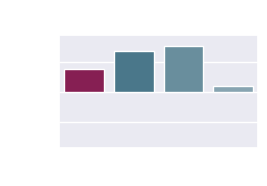

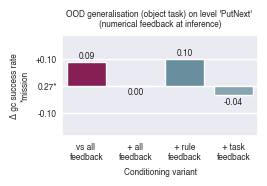

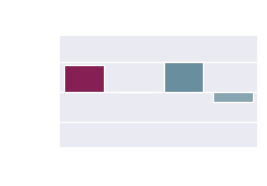

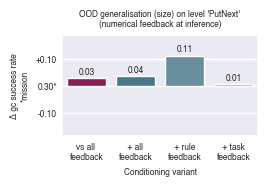

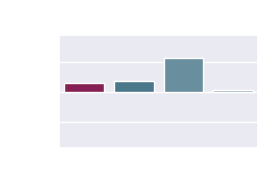

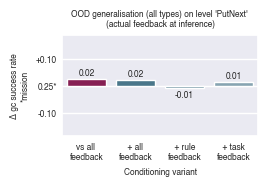

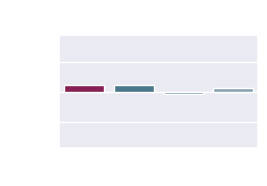

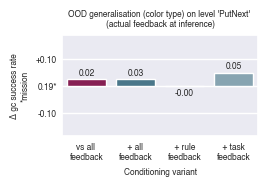

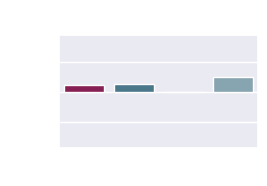

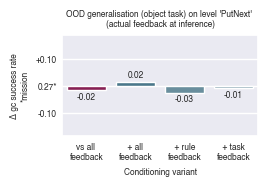

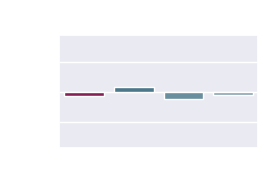

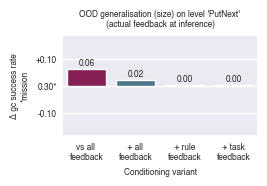

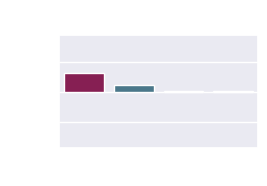

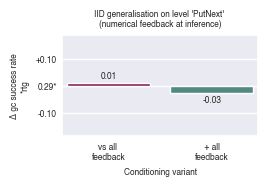

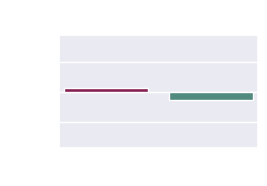

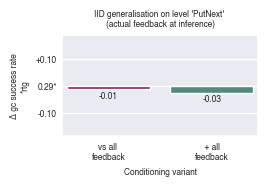

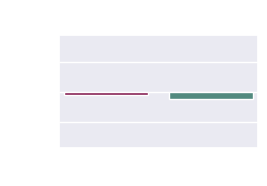

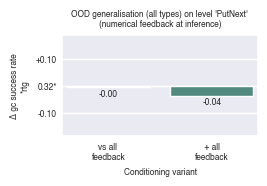

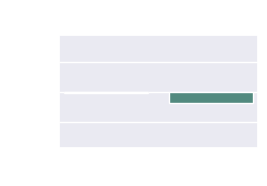

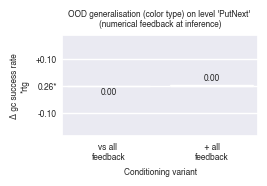

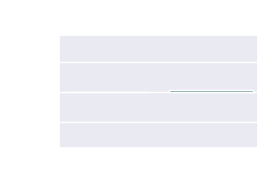

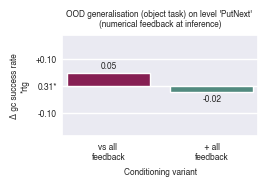

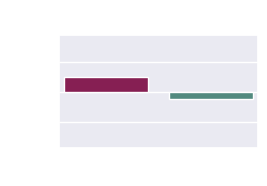

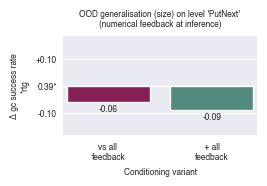

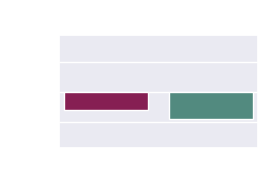

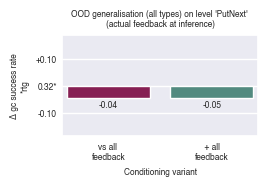

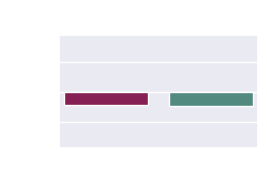

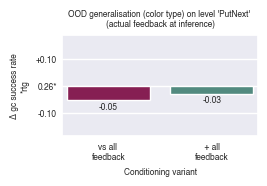

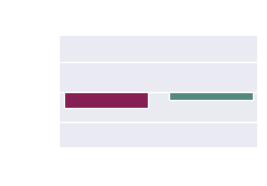

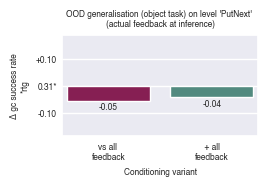

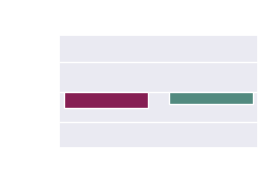

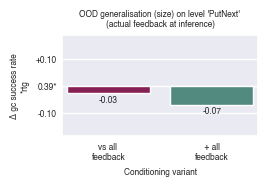

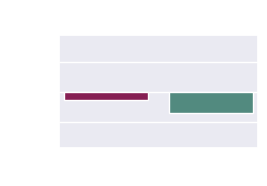

PUTNEXTLOCAL


,conditioning,Mean,Std,Min,Max,ood_type,eval_type,feedback_at_inference,Delta (Mean),reference
0,all feedback,0.183594,0.211585,0.0,0.75,None,iid_generalisation,numerical,0.0488,mission
1,mission,0.134766,0.179956,0.0,0.75,None,iid_generalisation,numerical,0.0000,mission
2,mission + all feedback,0.183594,0.222911,0.0,0.75,None,iid_generalisation,numerical,0.0488,mission
3,mission + rule feedback,0.207031,0.258915,0.0,1.00,None,iid_generalisation,numerical,0.0723,mission
4,mission + task feedback,0.121094,0.208067,0.0,1.00,None,iid_generalisation,numerical,-0.0137,mission
5,all feedback,0.245117,0.243759,0.0,1.00,all types,ood_generalisation,numerical,0.0962,mission
6,mission,0.148926,0.197622,0.0,1.00,all types,ood_generalisation,numerical,0.0000,mission
7,mission + all feedback,0.210449,0.239808,0.0,1.00,all types,ood_generalisation,numerical,0.0615,mission
8,mission + rule feedback,0.213379,0.255089,0.0,1.00,all types,ood_generalisation,numerical,0.0645,mission
9,mission + task feedback,0.178711,0.221288,0.0,1.00,all types,ood_generalisation,numerical,0.0298,mission


,conditioning,eval_type,ood_type,diff
119,rtg + task feedback,ood_generalisation,size,-0.0957
114,rtg + task feedback,ood_generalisation,object_task,-0.0684
109,rtg + task feedback,ood_generalisation,color_type,-0.0488
99,rtg + task feedback,ood_generalisation,all types,-0.0674
104,rtg + task feedback,ood_generalisation,agent_loc,-0.0566
94,rtg + task feedback,iid_generalisation,None,-0.0586
118,rtg + rule feedback,ood_generalisation,size,-0.0079
113,rtg + rule feedback,ood_generalisation,object_task,-0.0215
108,rtg + rule feedback,ood_generalisation,color_type,-0.0176
98,rtg + rule feedback,ood_generalisation,all types,-0.0205


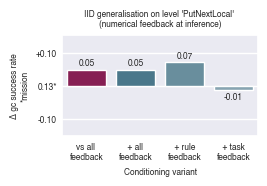

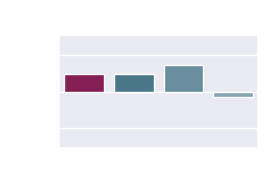

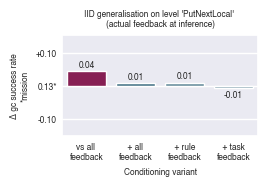

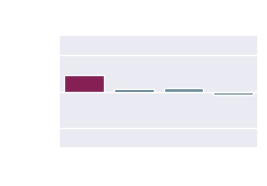

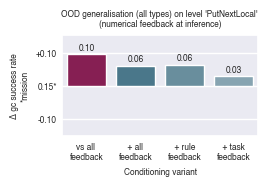

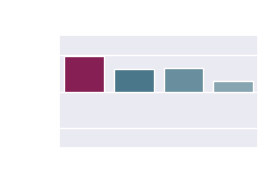

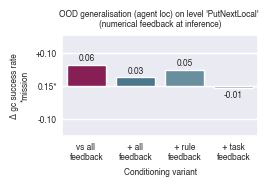

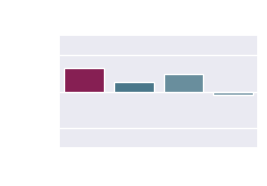

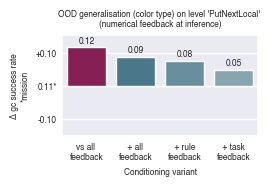

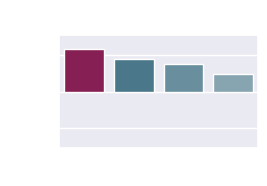

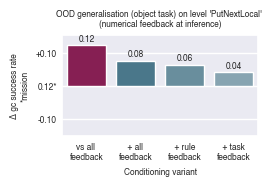

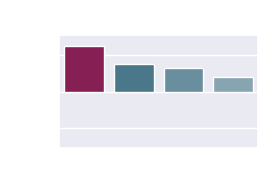

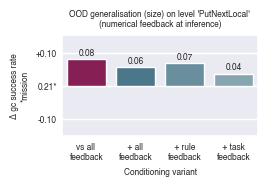

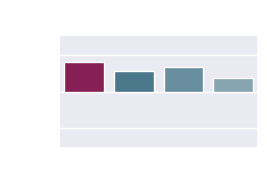

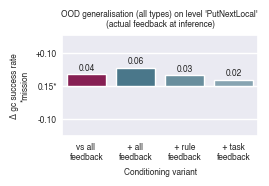

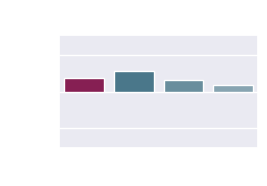

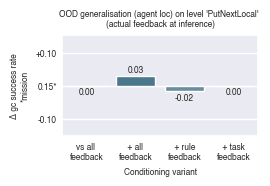

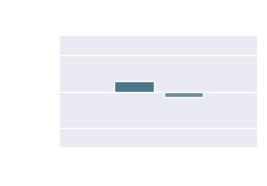

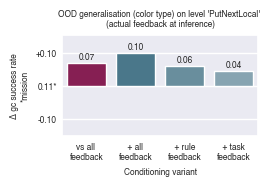

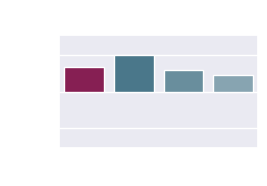

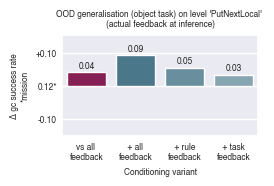

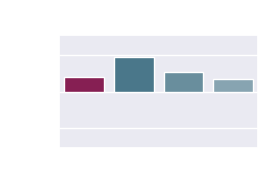

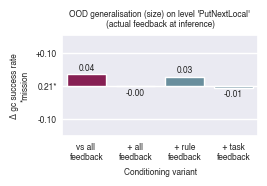

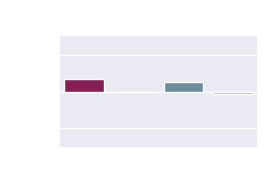

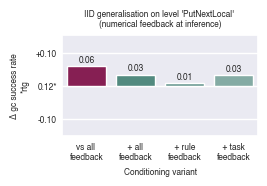

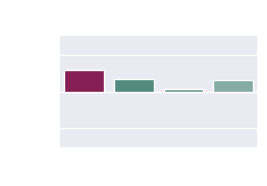

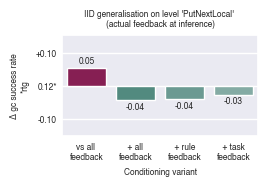

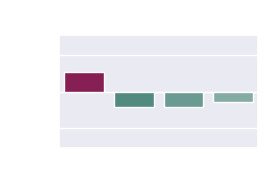

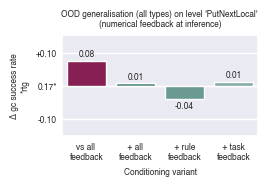

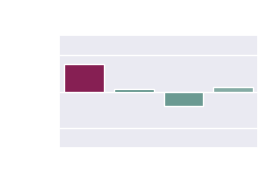

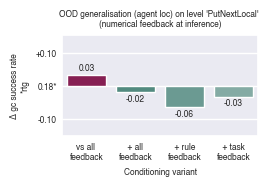

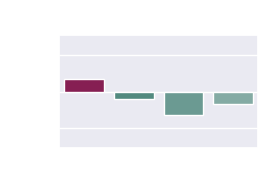

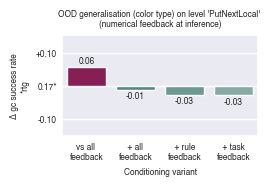

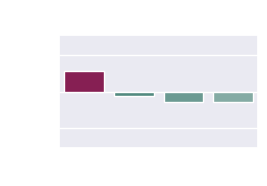

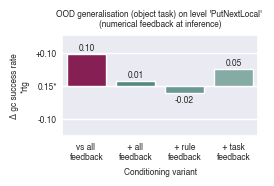

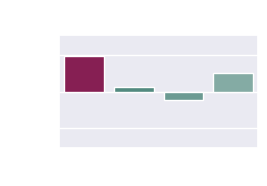

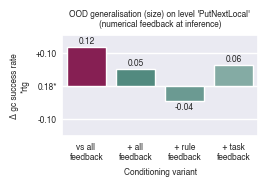

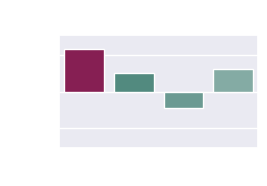

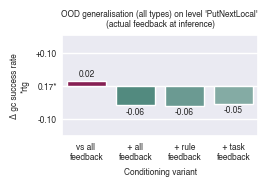

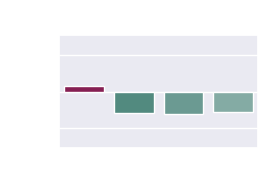

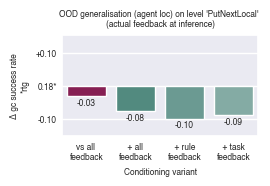

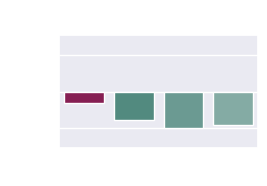

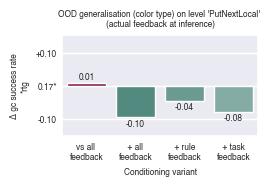

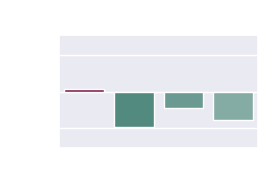

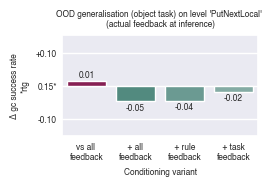

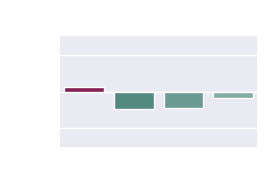

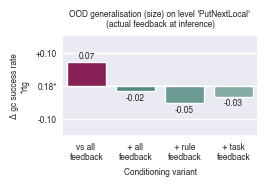

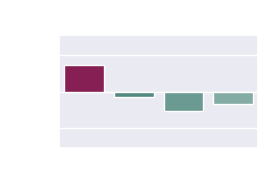

SYNTH


,conditioning,Mean,Std,Min,Max,ood_type,eval_type,feedback_at_inference,Delta (Mean),reference
0,all feedback,0.210938,0.377045,0.0,1.00,None,iid_generalisation,actual,-0.0312,mission
1,mission,0.242188,0.413761,0.0,1.00,None,iid_generalisation,actual,0.0000,mission
2,mission + all feedback,0.226562,0.407167,0.0,1.00,None,iid_generalisation,actual,-0.0156,mission
3,mission + rule feedback,0.222656,0.385814,0.0,1.00,None,iid_generalisation,actual,-0.0195,mission
4,mission + task feedback,0.238281,0.402819,0.0,1.00,None,iid_generalisation,actual,-0.0039,mission
5,all feedback,0.191406,0.329398,0.0,1.00,all types,ood_generalisation,actual,0.0267,mission
6,mission,0.164714,0.318160,0.0,1.00,all types,ood_generalisation,actual,0.0000,mission
7,mission + all feedback,0.167969,0.326349,0.0,1.00,all types,ood_generalisation,actual,0.0033,mission
8,mission + rule feedback,0.145833,0.303734,0.0,1.00,all types,ood_generalisation,actual,-0.0189,mission
9,mission + task feedback,0.156901,0.310748,0.0,1.00,all types,ood_generalisation,actual,-0.0078,mission


,conditioning,eval_type,ood_type,diff
59,rtg + all feedback,ood_generalisation,object_task,0.0293
56,rtg + all feedback,ood_generalisation,color_type,0.0723
50,rtg + all feedback,ood_generalisation,all types,0.0410
53,rtg + all feedback,ood_generalisation,agent_loc,0.0215
47,rtg + all feedback,iid_generalisation,None,0.0547
57,all feedback,ood_generalisation,object_task,-0.1406
54,all feedback,ood_generalisation,color_type,0.0625
48,all feedback,ood_generalisation,all types,0.0234
51,all feedback,ood_generalisation,agent_loc,0.1094
45,all feedback,iid_generalisation,None,-0.0899


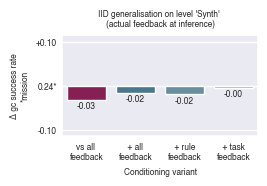

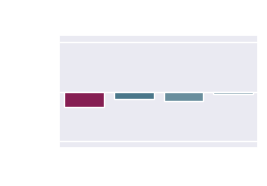

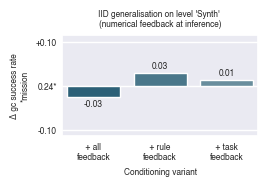

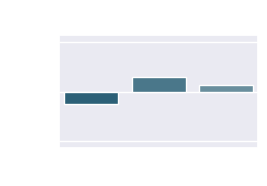

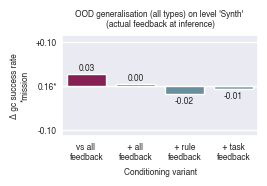

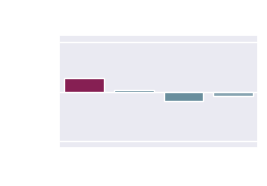

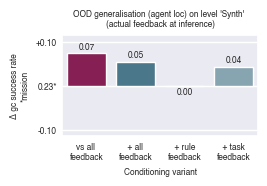

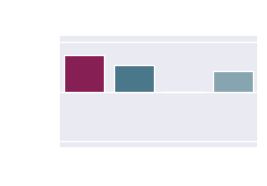

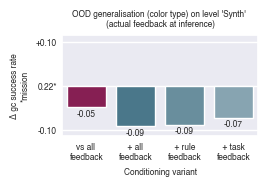

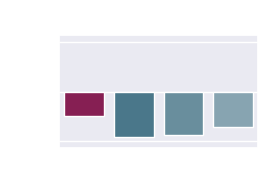

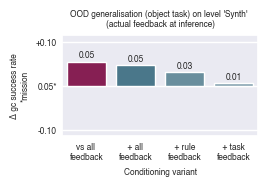

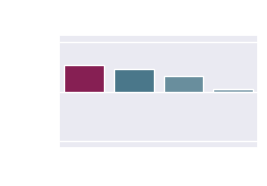

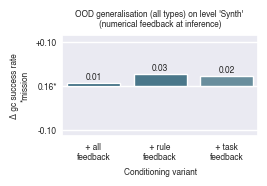

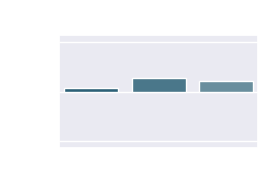

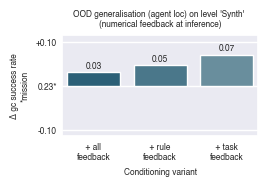

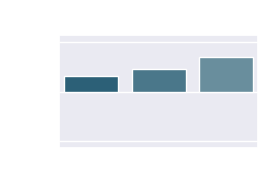

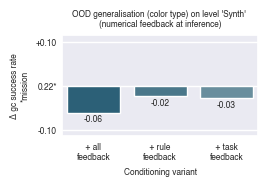

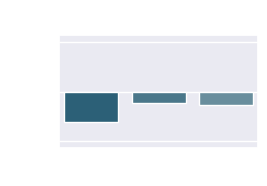

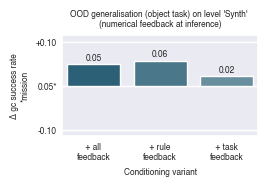

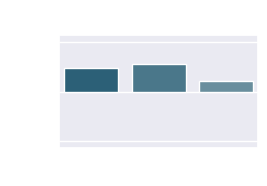

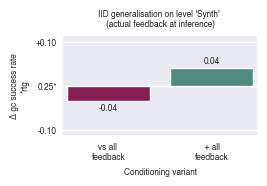

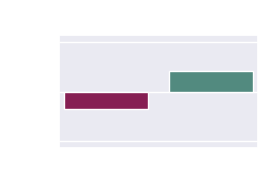

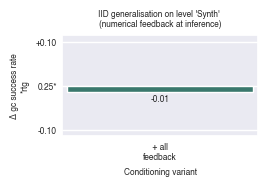

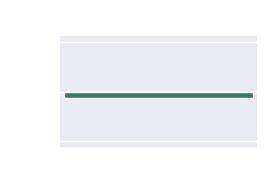

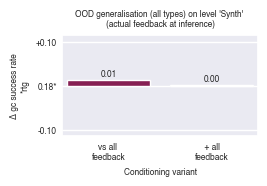

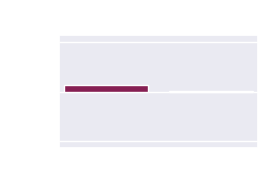

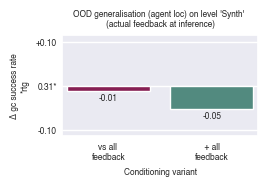

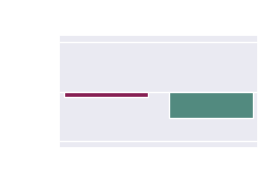

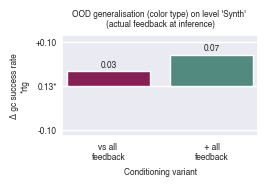

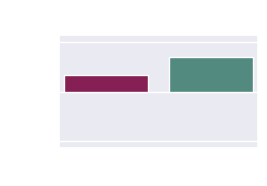

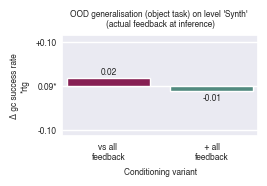

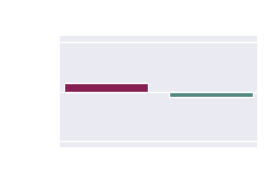

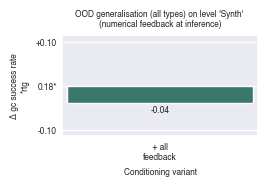

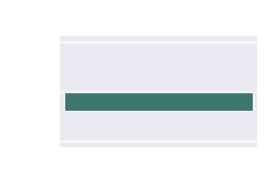

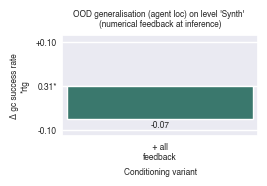

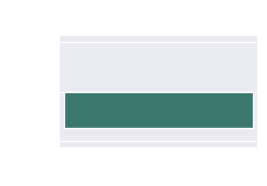

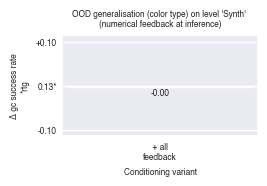

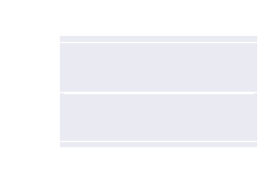

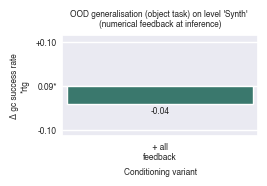

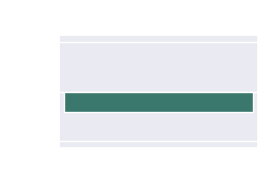

SYNTHLOC


,conditioning,Mean,Std,Min,Max,ood_type,eval_type,feedback_at_inference,Delta (Mean),reference
0,all feedback,0.298828,0.400613,0.0,1.0,None,iid_generalisation,actual,0.0293,mission
1,mission,0.269531,0.406165,0.0,1.0,None,iid_generalisation,actual,0.0000,mission
2,mission + all feedback,0.273438,0.420252,0.0,1.0,None,iid_generalisation,actual,0.0039,mission
3,mission + rule feedback,0.302734,0.409835,0.0,1.0,None,iid_generalisation,actual,0.0332,mission
4,mission + task feedback,0.283203,0.398535,0.0,1.0,None,iid_generalisation,actual,0.0137,mission
5,all feedback,0.261719,0.358854,0.0,1.0,all types,ood_generalisation,actual,0.0254,mission
6,mission,0.236328,0.358102,0.0,1.0,all types,ood_generalisation,actual,0.0000,mission
7,mission + all feedback,0.233398,0.364412,0.0,1.0,all types,ood_generalisation,actual,-0.0029,mission
8,mission + rule feedback,0.234375,0.368461,0.0,1.0,all types,ood_generalisation,actual,-0.0020,mission
9,mission + task feedback,0.244629,0.362902,0.0,1.0,all types,ood_generalisation,actual,0.0083,mission


,conditioning,eval_type,ood_type,diff
77,rtg + all feedback,ood_generalisation,rel_loc,0.0156
74,rtg + all feedback,ood_generalisation,object_task,0.0586
71,rtg + all feedback,ood_generalisation,color_type,0.0020
65,rtg + all feedback,ood_generalisation,all types,0.0054
68,rtg + all feedback,ood_generalisation,agent_loc,-0.0547
62,rtg + all feedback,iid_generalisation,None,0.0410
75,all feedback,ood_generalisation,rel_loc,-0.0176
72,all feedback,ood_generalisation,object_task,-0.0371
69,all feedback,ood_generalisation,color_type,-0.0390
63,all feedback,ood_generalisation,all types,-0.0269


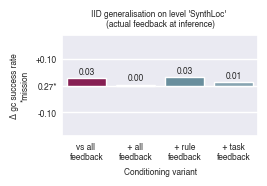

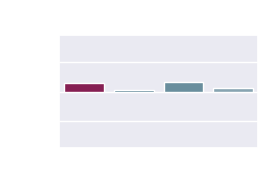

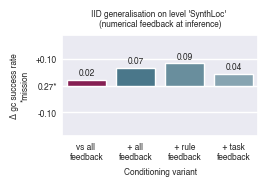

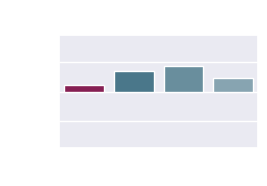

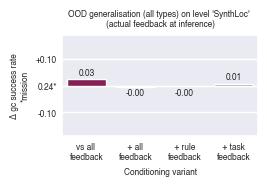

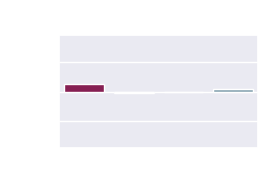

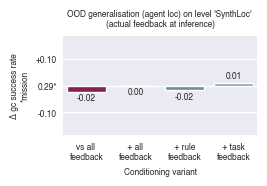

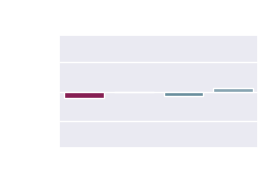

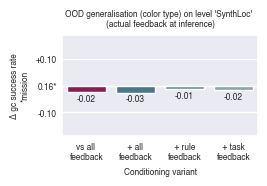

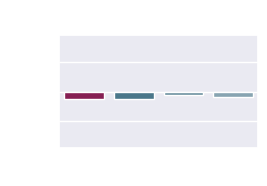

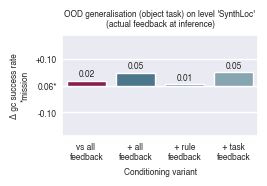

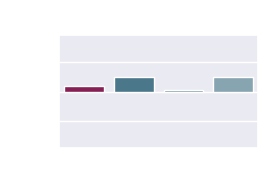

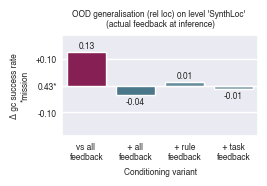

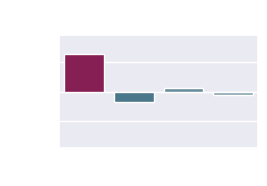

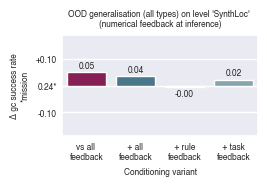

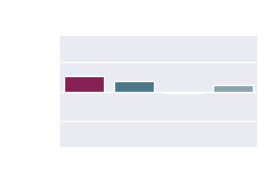

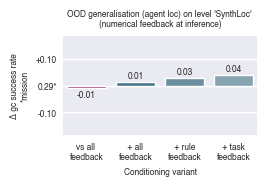

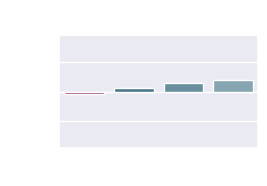

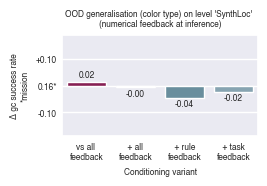

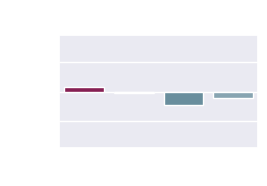

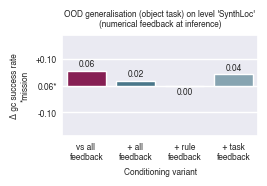

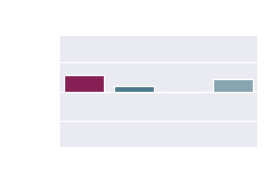

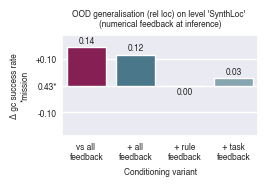

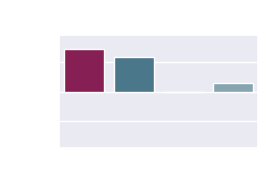

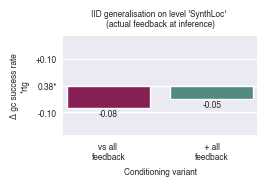

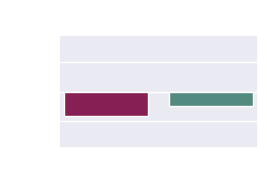

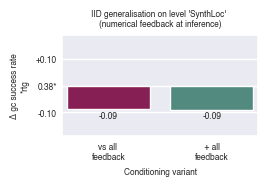

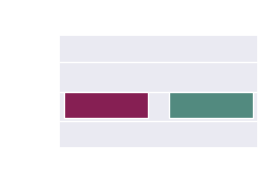

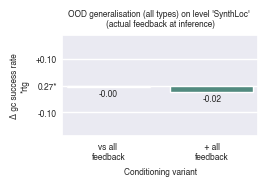

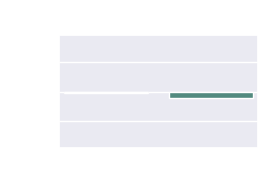

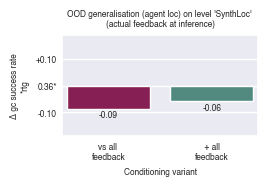

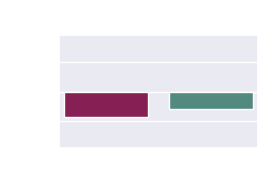

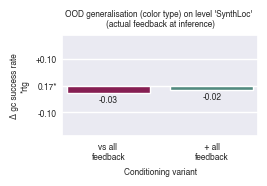

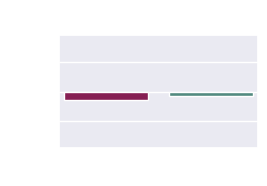

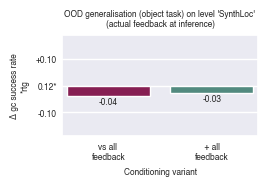

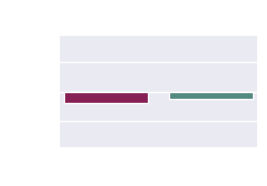

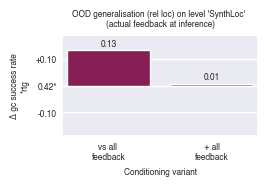

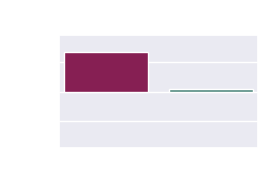

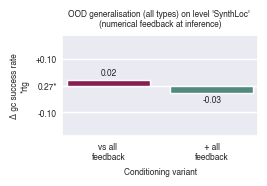

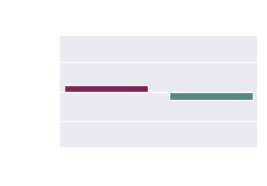

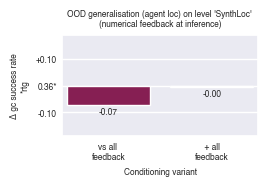

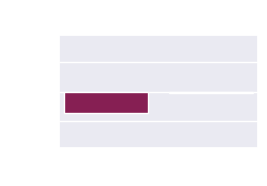

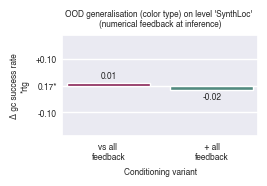

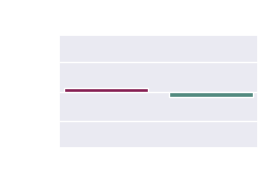

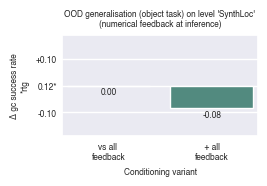

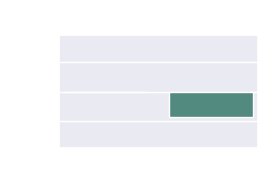

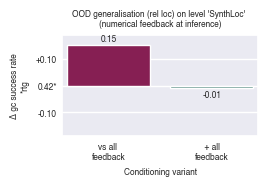

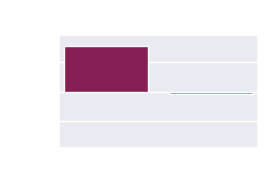

ALL LEVELS


,conditioning,Mean,Std,Min,Max,ood_type,eval_type,feedback_at_inference,Delta (Mean),reference
0,all feedback,0.290771,0.392046,0.0,1.00,None,iid_generalisation,actual,0.0261,mission
1,mission,0.264648,0.387715,0.0,1.00,None,iid_generalisation,actual,0.0000,mission
2,mission + all feedback,0.235352,0.374571,0.0,1.00,None,iid_generalisation,actual,-0.0293,mission
3,mission + rule feedback,0.220947,0.360837,0.0,1.00,None,iid_generalisation,actual,-0.0437,mission
4,mission + task feedback,0.293457,0.396947,0.0,1.00,None,iid_generalisation,actual,0.0288,mission
5,all feedback,0.268550,0.373409,0.0,1.00,all types,ood_generalisation,actual,-0.0004,mission
6,mission,0.268942,0.379963,0.0,1.00,all types,ood_generalisation,actual,0.0000,mission
7,mission + all feedback,0.226675,0.349270,0.0,1.00,all types,ood_generalisation,actual,-0.0423,mission
8,mission + rule feedback,0.223075,0.344495,0.0,1.00,all types,ood_generalisation,actual,-0.0459,mission
9,mission + task feedback,0.285301,0.385173,0.0,1.00,all types,ood_generalisation,actual,0.0164,mission


,conditioning,eval_type,ood_type,diff
104,rtg + task feedback,ood_generalisation,size,-0.1446
99,rtg + task feedback,ood_generalisation,rel_loc,-0.0234
94,rtg + task feedback,ood_generalisation,object_task,-0.0684
89,rtg + task feedback,ood_generalisation,color_type,-0.0701
79,rtg + task feedback,ood_generalisation,all types,-0.0724
84,rtg + task feedback,ood_generalisation,agent_loc,-0.0338
74,rtg + task feedback,iid_generalisation,None,-0.0527
103,rtg + rule feedback,ood_generalisation,size,-0.1073
98,rtg + rule feedback,ood_generalisation,rel_loc,0.0390
93,rtg + rule feedback,ood_generalisation,object_task,-0.0215


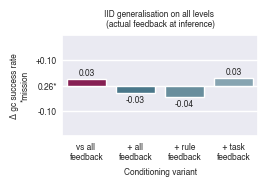

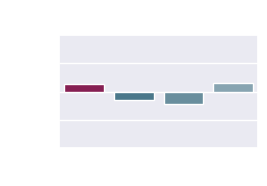

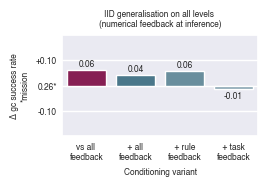

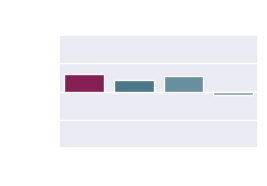

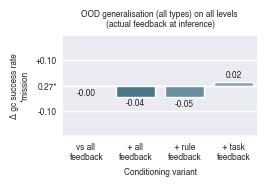

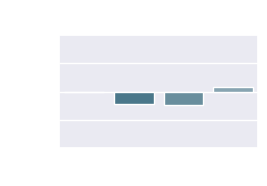

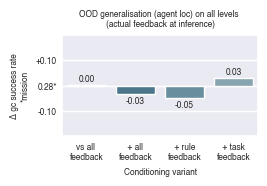

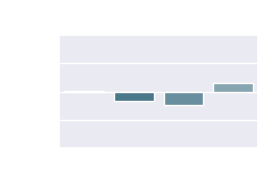

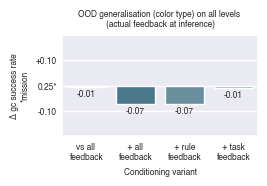

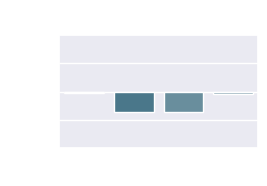

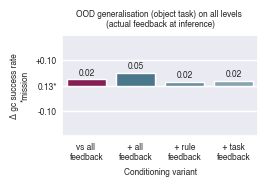

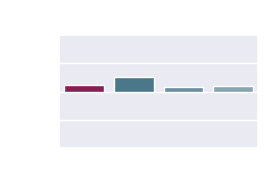

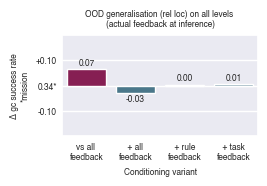

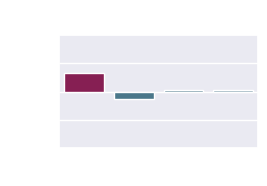

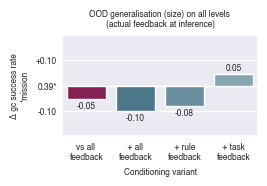

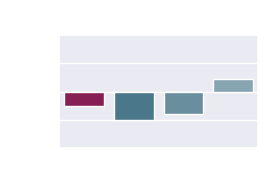

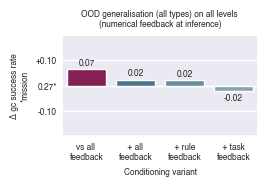

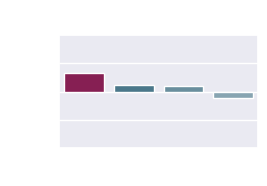

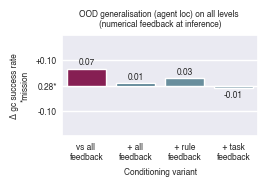

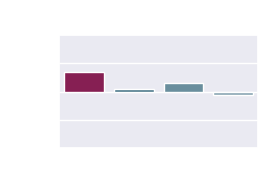

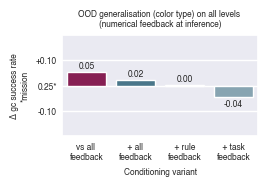

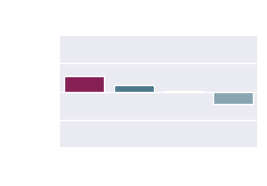

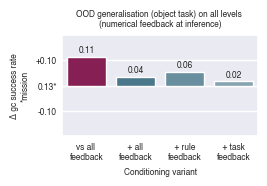

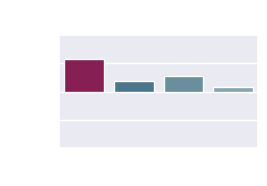

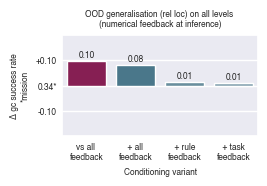

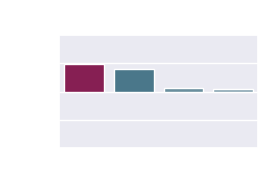

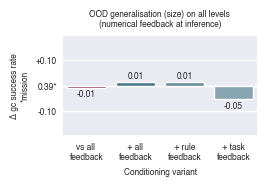

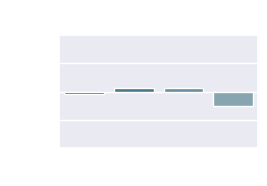

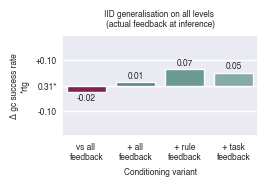

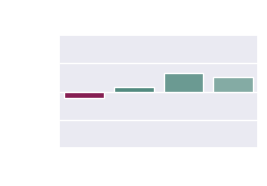

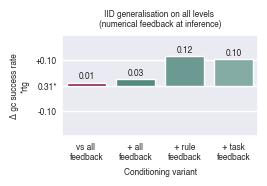

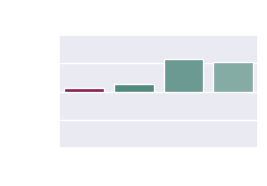

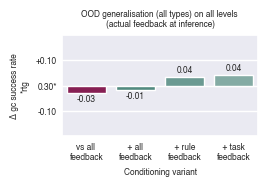

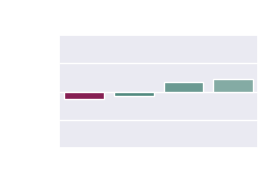

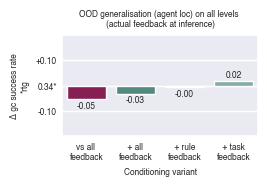

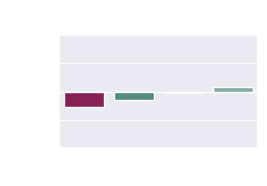

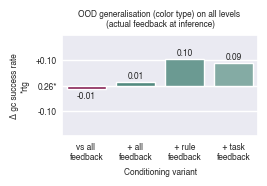

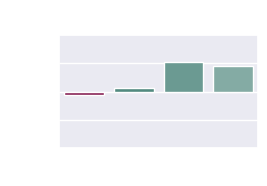

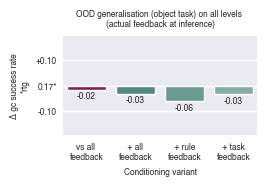

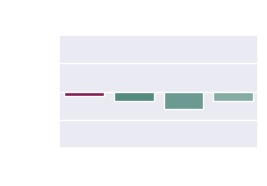

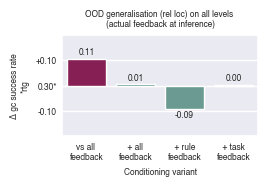

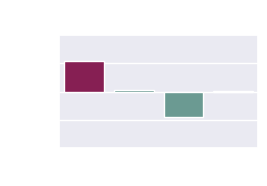

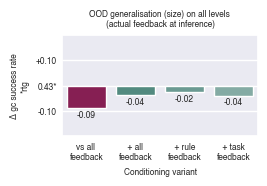

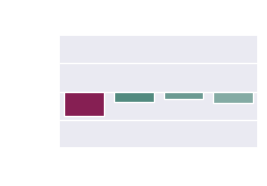

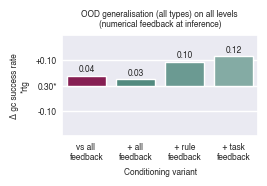

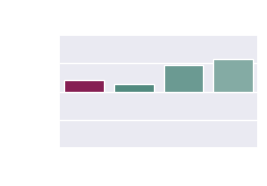

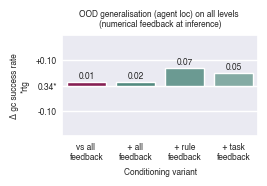

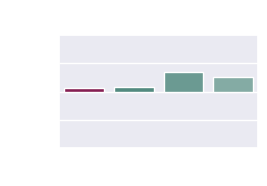

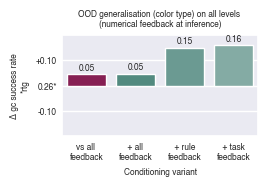

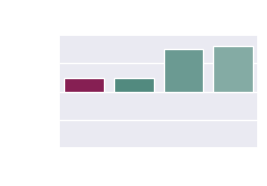

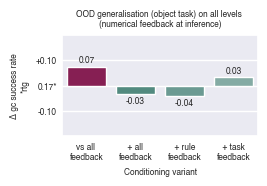

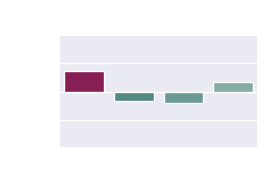

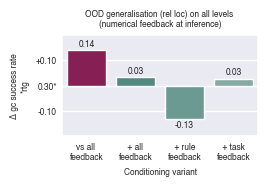

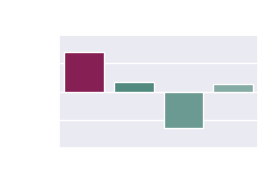

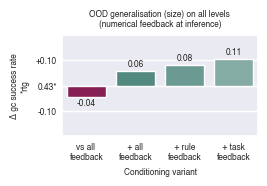

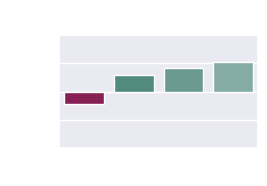

In [3403]:
comb_df = get_combined_df(data_home, level="")
for level in sorted(comb_df["level"].unique()):
    print(level.upper())
    level_df = comb_df[comb_df["level"] == level]
    results_df = combine_results(level_df, metric)
    inference_mode_diffs = get_inference_mode_diffs(results_df)
    save_results_as_csv(inference_mode_diffs, level, "inference_mode_diff", output_path)
    save_results_as_csv(results_df, level, metric, output_path)
    plot_results(results_df, level, metric, colors, size, output_path)
    print("===" * 10)

print("ALL LEVELS")
results_df = combine_results(comb_df, metric)
inference_mode_diffs = get_inference_mode_diffs(results_df)
save_results_as_csv(inference_mode_diffs, "all_levels", "inference_mode_diff", output_path)
save_results_as_csv(results_df, "all_levels", metric, output_path)
plot_results(results_df, "all_levels", metric, colors, size, output_path)